# Total 0-75

In [7]:
%pip install shap
%matplotlib inline
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap

from catboost import Pool, CatBoostRegressor

# Data

In [9]:
df = pd.read_stata('W:\COVID19\std_inz0_75.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [10]:
df.head()

,D_v404,D_v405,D_v406,D_v423,D_v424,D_v425,D_v442,D_Abhaen,D_Auslae,D_v483,...,G_Pendler_Saarbru,G_Pendler_Potsdam,G_latitude,G_longitude,G_distance_Ischgl,Flag100_Pendler_Coesfeld,Flag100_Pendler_Rosenheim,Flag100_Pendler_Goettingen,std_inz_0to75,eastwest
0,46.000000,12.4,-2.5,0.93,2.4,12.3,1.04,38.299999,9.1,3.2,...,0.0,0.0,50.549999,7.116667,457.259216,0.0,0.0,0.0,7.929436,1.0
1,43.000000,16.0,-3.5,0.94,4.2,7.6,1.00,29.900000,8.0,2.9,...,0.0,0.0,48.466667,11.133333,173.721573,0.0,0.0,0.0,4.718663,1.0
2,42.500000,14.9,-2.3,0.88,4.0,6.3,0.98,28.900000,12.6,4.0,...,0.0,0.0,48.400002,9.983334,156.045456,0.0,0.0,0.0,8.526311,1.0
3,49.700001,-1.4,-7.5,0.88,-4.3,-13.3,1.04,50.799999,3.2,2.0,...,0.0,0.0,50.983334,12.433333,468.846863,0.0,0.0,0.0,1.614463,0.0
4,44.700001,9.4,-1.5,0.93,-0.3,-7.4,1.02,34.099998,7.2,2.1,...,0.0,0.0,50.683334,7.650000,451.906799,0.0,0.0,0.0,5.352468,1.0


In [11]:
Y = df['std_inz_0to75']
X = df.loc[:, ~df.columns.isin(['std_inz_0to75', 'eastwest'])]

# RF model

In [49]:
rfr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
rf=rfr.fit(X, Y)  

# R2 RF model

In [50]:
rf.score(X, Y)

0.8169438303301793

# CatBoost Model

In [36]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0)
#train the model
cb = model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(train_pool)
#print(preds)

Learning rate set to 0.033171
0:	learn: 14.3092057	total: 7.88ms	remaining: 7.87s
1:	learn: 14.2145929	total: 14.5ms	remaining: 7.26s
2:	learn: 14.1218526	total: 21ms	remaining: 6.99s
3:	learn: 14.0466115	total: 27.2ms	remaining: 6.78s
4:	learn: 13.9518253	total: 34.2ms	remaining: 6.8s
5:	learn: 13.8550082	total: 40.8ms	remaining: 6.76s
6:	learn: 13.7644301	total: 48.1ms	remaining: 6.82s
7:	learn: 13.6725264	total: 55.2ms	remaining: 6.85s
8:	learn: 13.5839751	total: 62.7ms	remaining: 6.91s
9:	learn: 13.4896124	total: 69.2ms	remaining: 6.85s
10:	learn: 13.4005818	total: 75.4ms	remaining: 6.78s
11:	learn: 13.3163907	total: 81.9ms	remaining: 6.75s
12:	learn: 13.2330409	total: 88.1ms	remaining: 6.69s
13:	learn: 13.1448170	total: 94.4ms	remaining: 6.65s
14:	learn: 13.0591013	total: 100ms	remaining: 6.6s
15:	learn: 12.9743601	total: 107ms	remaining: 6.55s
16:	learn: 12.8925191	total: 114ms	remaining: 6.58s
17:	learn: 12.8119589	total: 120ms	remaining: 6.53s
18:	learn: 12.7328931	total: 126ms

167:	learn: 6.5563330	total: 1.07s	remaining: 5.29s
168:	learn: 6.5413091	total: 1.07s	remaining: 5.28s
169:	learn: 6.5228698	total: 1.08s	remaining: 5.28s
170:	learn: 6.5053260	total: 1.09s	remaining: 5.27s
171:	learn: 6.4929015	total: 1.09s	remaining: 5.26s
172:	learn: 6.4767942	total: 1.1s	remaining: 5.26s
173:	learn: 6.4587964	total: 1.1s	remaining: 5.25s
174:	learn: 6.4417326	total: 1.11s	remaining: 5.24s
175:	learn: 6.4065796	total: 1.12s	remaining: 5.24s
176:	learn: 6.3890389	total: 1.12s	remaining: 5.23s
177:	learn: 6.3588123	total: 1.13s	remaining: 5.22s
178:	learn: 6.3359635	total: 1.14s	remaining: 5.21s
179:	learn: 6.3201484	total: 1.14s	remaining: 5.21s
180:	learn: 6.3015391	total: 1.15s	remaining: 5.2s
181:	learn: 6.2861347	total: 1.16s	remaining: 5.19s
182:	learn: 6.2677076	total: 1.16s	remaining: 5.18s
183:	learn: 6.2519596	total: 1.17s	remaining: 5.18s
184:	learn: 6.2371784	total: 1.17s	remaining: 5.17s
185:	learn: 6.2219563	total: 1.18s	remaining: 5.16s
186:	learn: 6.2

340:	learn: 3.6020283	total: 2.14s	remaining: 4.14s
341:	learn: 3.5742876	total: 2.15s	remaining: 4.13s
342:	learn: 3.5480716	total: 2.15s	remaining: 4.13s
343:	learn: 3.5430643	total: 2.16s	remaining: 4.12s
344:	learn: 3.5316227	total: 2.17s	remaining: 4.11s
345:	learn: 3.5289342	total: 2.17s	remaining: 4.11s
346:	learn: 3.5120212	total: 2.18s	remaining: 4.1s
347:	learn: 3.4919787	total: 2.18s	remaining: 4.09s
348:	learn: 3.4698133	total: 2.19s	remaining: 4.09s
349:	learn: 3.4468181	total: 2.2s	remaining: 4.08s
350:	learn: 3.4446504	total: 2.2s	remaining: 4.07s
351:	learn: 3.4247753	total: 2.21s	remaining: 4.07s
352:	learn: 3.4126540	total: 2.21s	remaining: 4.06s
353:	learn: 3.3943105	total: 2.22s	remaining: 4.05s
354:	learn: 3.3829257	total: 2.23s	remaining: 4.05s
355:	learn: 3.3723553	total: 2.23s	remaining: 4.04s
356:	learn: 3.3603243	total: 2.24s	remaining: 4.03s
357:	learn: 3.3396201	total: 2.25s	remaining: 4.03s
358:	learn: 3.3170443	total: 2.25s	remaining: 4.02s
359:	learn: 3.3

509:	learn: 1.9063284	total: 3.21s	remaining: 3.09s
510:	learn: 1.8957090	total: 3.22s	remaining: 3.08s
511:	learn: 1.8845854	total: 3.23s	remaining: 3.08s
512:	learn: 1.8763462	total: 3.23s	remaining: 3.07s
513:	learn: 1.8706264	total: 3.24s	remaining: 3.06s
514:	learn: 1.8641331	total: 3.25s	remaining: 3.06s
515:	learn: 1.8493840	total: 3.25s	remaining: 3.05s
516:	learn: 1.8458728	total: 3.26s	remaining: 3.04s
517:	learn: 1.8403885	total: 3.26s	remaining: 3.04s
518:	learn: 1.8307432	total: 3.27s	remaining: 3.03s
519:	learn: 1.8249614	total: 3.28s	remaining: 3.02s
520:	learn: 1.8188674	total: 3.28s	remaining: 3.02s
521:	learn: 1.8123562	total: 3.29s	remaining: 3.01s
522:	learn: 1.8054314	total: 3.29s	remaining: 3.01s
523:	learn: 1.7992748	total: 3.3s	remaining: 3s
524:	learn: 1.7950478	total: 3.31s	remaining: 2.99s
525:	learn: 1.7898126	total: 3.31s	remaining: 2.99s
526:	learn: 1.7815775	total: 3.32s	remaining: 2.98s
527:	learn: 1.7742022	total: 3.33s	remaining: 2.97s
528:	learn: 1.76

673:	learn: 1.0724788	total: 4.28s	remaining: 2.07s
674:	learn: 1.0693469	total: 4.29s	remaining: 2.06s
675:	learn: 1.0675421	total: 4.29s	remaining: 2.06s
676:	learn: 1.0648092	total: 4.3s	remaining: 2.05s
677:	learn: 1.0634654	total: 4.31s	remaining: 2.04s
678:	learn: 1.0590146	total: 4.31s	remaining: 2.04s
679:	learn: 1.0543302	total: 4.32s	remaining: 2.03s
680:	learn: 1.0486305	total: 4.32s	remaining: 2.02s
681:	learn: 1.0438694	total: 4.33s	remaining: 2.02s
682:	learn: 1.0387831	total: 4.34s	remaining: 2.01s
683:	learn: 1.0383781	total: 4.34s	remaining: 2.01s
684:	learn: 1.0334676	total: 4.35s	remaining: 2s
685:	learn: 1.0305182	total: 4.36s	remaining: 1.99s
686:	learn: 1.0277022	total: 4.36s	remaining: 1.99s
687:	learn: 1.0222758	total: 4.37s	remaining: 1.98s
688:	learn: 1.0178014	total: 4.37s	remaining: 1.97s
689:	learn: 1.0125268	total: 4.38s	remaining: 1.97s
690:	learn: 1.0069760	total: 4.38s	remaining: 1.96s
691:	learn: 1.0016927	total: 4.39s	remaining: 1.95s
692:	learn: 0.99

849:	learn: 0.5760259	total: 5.36s	remaining: 945ms
850:	learn: 0.5734452	total: 5.36s	remaining: 939ms
851:	learn: 0.5714413	total: 5.37s	remaining: 933ms
852:	learn: 0.5689120	total: 5.38s	remaining: 926ms
853:	learn: 0.5677392	total: 5.38s	remaining: 920ms
854:	learn: 0.5663812	total: 5.39s	remaining: 914ms
855:	learn: 0.5649432	total: 5.39s	remaining: 907ms
856:	learn: 0.5629872	total: 5.4s	remaining: 901ms
857:	learn: 0.5617747	total: 5.41s	remaining: 895ms
858:	learn: 0.5603675	total: 5.41s	remaining: 889ms
859:	learn: 0.5590161	total: 5.42s	remaining: 882ms
860:	learn: 0.5559445	total: 5.42s	remaining: 876ms
861:	learn: 0.5539116	total: 5.43s	remaining: 870ms
862:	learn: 0.5520366	total: 5.44s	remaining: 863ms
863:	learn: 0.5497440	total: 5.44s	remaining: 857ms
864:	learn: 0.5478573	total: 5.45s	remaining: 851ms
865:	learn: 0.5455231	total: 5.46s	remaining: 844ms
866:	learn: 0.5446391	total: 5.46s	remaining: 838ms
867:	learn: 0.5436309	total: 5.47s	remaining: 832ms
868:	learn: 0

# R2 CatBoost

In [42]:
cb.score(X, Y)

0.9994066010320601

# SHAP values 

# RF

In [51]:
shap_values = shap.TreeExplainer(rf).shap_values(X)

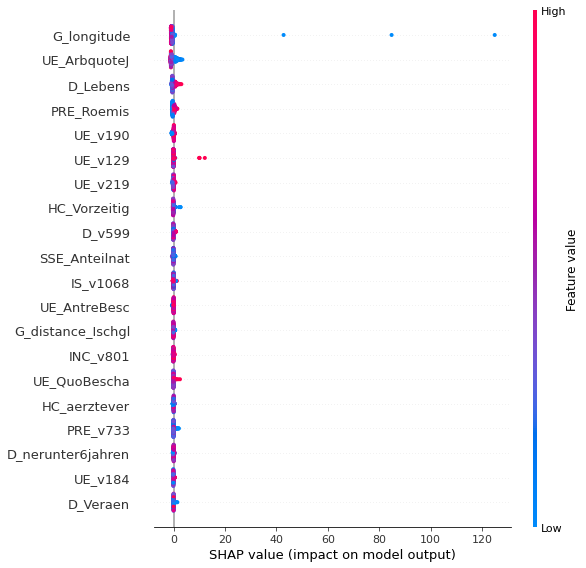

In [52]:
shap.summary_plot(shap_values, X,max_display=20) 

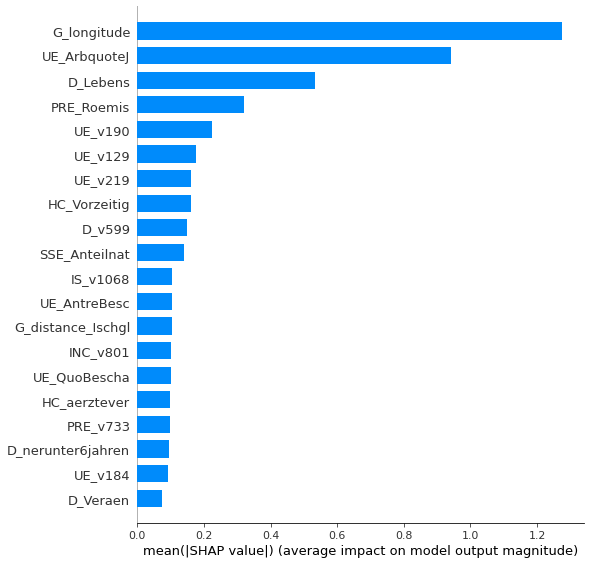

In [53]:
shap.summary_plot(shap_values, X, plot_type="bar",max_display=20)

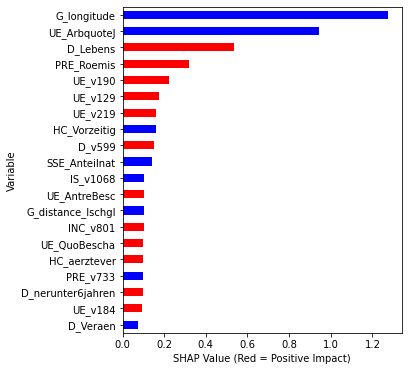

In [10]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X) 

# CatBoost

In [37]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

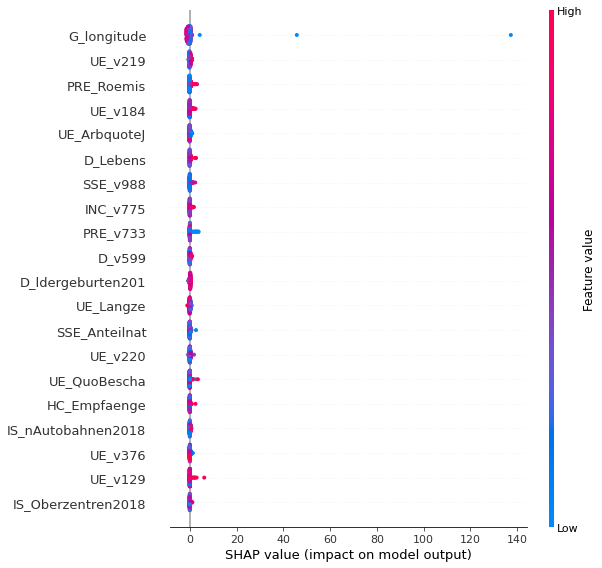

In [38]:
shap.summary_plot(shap_values_cb, X,max_display=20)  #TreeExpliner

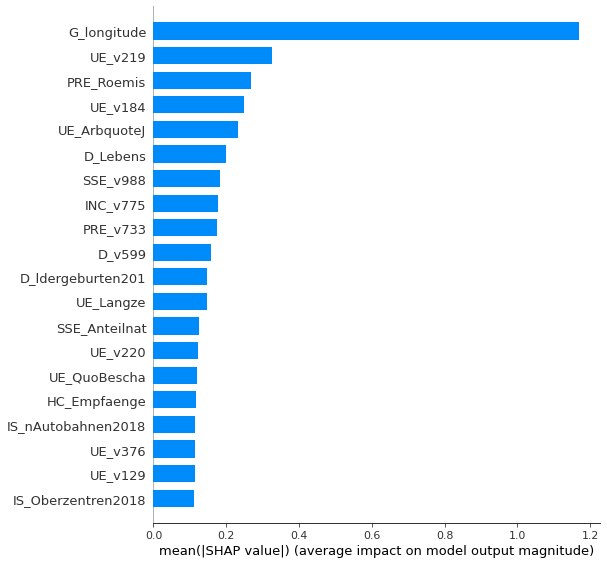

In [39]:
shap.summary_plot(shap_values_cb, X, plot_type="bar",max_display=20)

invalid value encountered in true_divide
invalid value encountered in true_divide


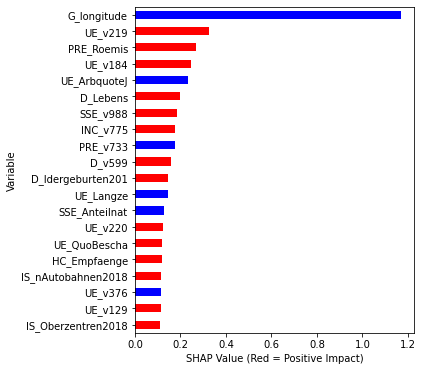

In [40]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 